In [1]:
import torch
import matplotlib.pyplot as plt
from statistics import mean
from tqdm import tqdm
import pandas as pd
%matplotlib inline

In [2]:
from graph_generation_trade import dict_snapshots_trade, temporal_data_trade

snapshots_trade = list(dict_snapshots_trade.values())

from models_and_utils import (
    data_split, train_snapshots, test_snapshots, apply_negative_sampling
)

In [3]:
def train_snapshots(model, graph_snapshots_train, optimiser, epochs):

    model.train(True)
    loss_epochs_dict = {}

    for epoch in tqdm(range(epochs)):
        
        losses_list = []
        non_zero_gradients = 0

        for snapshot in graph_snapshots_train:
            optimiser.zero_grad()

            edge_weights_pred = model(snapshot)

            loss = torch.mean((edge_weights_pred - snapshot.edge_weights)**2)
            loss.backward()
            
            for param in model.parameters():
                if param.grad is not None:
                    if torch.sum(param.grad) != 0:
                        non_zero_gradients += 1
            
            optimiser.step()
            losses_list.append(loss.item())

        if non_zero_gradients == 0:
            print("Warning: No non-zero gradients found in epoch {}".format(epoch))

        if epoch % 10 == 0:
            plt.scatter(edge_weights_pred.detach().numpy(), snapshot.edge_weights.detach().numpy())
            plt.xlabel('pred')
            plt.ylabel('true')
            plt.xlim(left=0)
            plt.show()

        avg_epoch_loss = mean(losses_list)
        loss_epochs_dict[epoch+1] = avg_epoch_loss 

    loss_epochs_df = pd.DataFrame(loss_epochs_dict.items(), columns=['epoch', 'loss'])
    return loss_epochs_df

def test_snapshots(model, graph_snapshots_test):
    with torch.no_grad():
        model.eval()
        loss = 0
        for snapshot in graph_snapshots_test:
            edge_weights_pred = model(snapshot)
            mse = torch.mean((edge_weights_pred - snapshot.edge_weights)**2)
            loss += mse
        loss = loss / (len(graph_snapshots_test))
        print(f'MSE = {loss.item():.4f}')

In [4]:
data = snapshots_trade
data_train, data_test = data_split(graph_snapshots=data, split_ratio=0.9)

In [5]:
# from models_and_utils import ModelMPNN

# in_channels = data[0].x.shape[1]
# hidden_size = 4
# num_nodes = data[0].x.shape[0]
# window = 1
# dropout_p = 0.0
# model1 = ModelMPNN(in_channels, hidden_size, num_nodes, window, dropout_p)
# model1.to(device)

# lr = 0.005
# optimiser = torch.optim.Adam(model1.parameters(), lr=lr)
# epochs = 50

# results = train_snapshots(model1, data_train, optimiser, epochs)
# results['loss'].plot()
# plt.show()

# results = test_snapshots(model1, data_test)

In [ ]:
# from models_and_utils import ModelEVOLVE

# in_channels = hidden_size = data[0].x.shape[1]
# num_nodes = data[0].x.shape[0]
# window = 1
# dropout_p = 0.0

# model2 = ModelEVOLVE(num_nodes, hidden_size, in_channels, dropout_p)

# lr = 0.0005
# epochs = 10
# optimiser = torch.optim.Adam(model2.parameters(), lr=lr)

# results = train_snapshots(model2, data_train, optimiser, epochs)
# results['loss'].plot()
# plt.show()

# # results = test_snapshots(model2, data_test)

  0%|          | 0/5 [00:00<?, ?it/s]

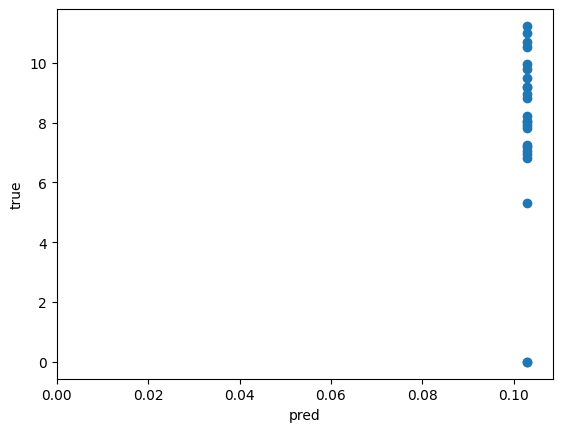

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


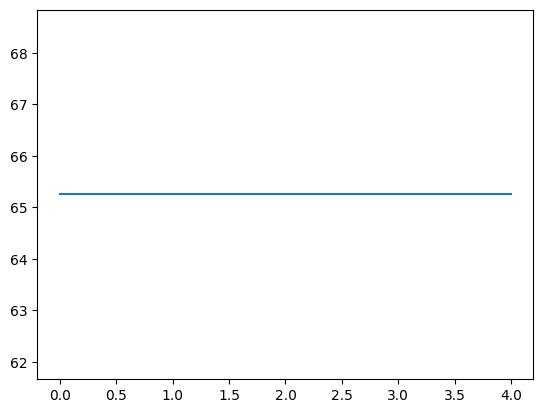

MSE = 71.8461


In [12]:
from models_and_utils import ModelA3TGCN

in_channels = snapshots_trade[0].x.shape[1]
hidden_size = 4
dropout_p = 0.2
periods = 1

model3 = ModelA3TGCN(in_channels, hidden_size, dropout_p, periods)

lr = 0
epochs = 5
optimiser = torch.optim.Adam(model3.parameters(), lr=lr)

train_snapshots(model3, data_train, optimiser, epochs)['loss'].plot()
plt.show()

test_snapshots(model3, data_test)

In [11]:
model3

ModelA3TGCN(
  (encoder): EncoderA3TGCN(
    (A3TGCN): A3TGCN(
      (_base_tgcn): TGCN(
        (conv_z): GCNConv(1, 4)
        (linear_z): Linear(in_features=8, out_features=4, bias=True)
        (conv_r): GCNConv(1, 4)
        (linear_r): Linear(in_features=8, out_features=4, bias=True)
        (conv_h): GCNConv(1, 4)
        (linear_h): Linear(in_features=8, out_features=4, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=8, out_features=4, bias=True)
    (lin2): Linear(in_features=4, out_features=1, bias=True)
  )
)